This notebook takes a CSV file of PIREPS reports and creates the normalized risk ratio for moderate or greater turbulence.

In [1]:
# Import modules
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd

In [2]:
##### START OPTIONS #####

# Location of pireps files
pireps_file = '../data/low_fl.csv'

# Grid structure
xbins_conus = np.arange(-129, -66, 0.5)
ybins_conus = np.arange(25.25, 50.5, 0.625)

# Save location
sdir = '../test/low_fl/'

#####  END OPTIONS  #####

In [22]:
### Read PIREPS reports
pireps = pd.read_csv(pireps_file)

### Loop across the PIREPS reports and store in the appropriate grid cell
totals= np.zeros((ybins_conus.size, xbins_conus.size))
modg = np.zeros((ybins_conus.size, xbins_conus.size))
for ind, row in pireps.iterrows():
    
    # Get the hour
    hr = row.Dec_hr
    date = datetime.strptime(row.DateTime, '%Y-%m-%d %H:%M:%S')

    # Set stuff up on first pass
    if (ind == 0):
        last_hour = hr
        last_day = date.timetuple().tm_yday
        last_date = date

    # Check if still in same window
    if (date.timetuple().tm_yday != last_day):
        # Output to a numpy file
        np.save(f'{sdir}/{last_date.strftime("%Y%m%d")}_turbulence_norm.npy',
            modg/totals)
        np.save(f'{sdir}/{last_date.strftime("%Y%m%d")}_turbulence_modg.npy',
            modg)
        np.save(f'{sdir}/{last_date.strftime("%Y%m%d")}_turbulence_totals.npy',
            totals)

        # Update variables
        last_day = date.timetuple().tm_yday
        last_date = date
        #date = date.replace(hour=hr, minute=0, second=0)
        totals[:] = 0
        modg[:] = 0

    # Match to a grid cell
    yind = np.argmin((row.LAT-ybins_conus)**2)
    xind = np.argmin((row.LON-xbins_conus)**2)

    # Update counts
    totals[yind,xind] += 1
    if (row.Intensity >= 2):
        modg[yind,xind] += 1

    last_hour = hr



/tmp/ipykernel_13955/3337005035.py:42: RuntimeWarning: invalid value encountered in true_divide
  modg/totals)


35.0
140.0
67.0


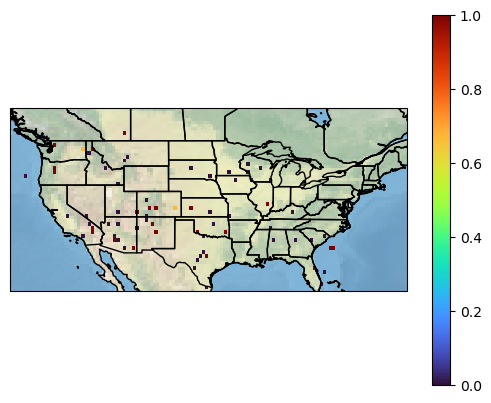

In [21]:
### Load up some data to test
norm = np.load(f'{sdir}/20111212_turbulence_norm.npy')
modg = np.load(f'{sdir}/20111212_turbulence_modg.npy')
totals = np.load(f'{sdir}/20111212_turbulence_totals.npy')

print(modg.max())
print(np.sum(totals))
print(np.sum(modg))

# Threshold based on totals count
norm[totals < 1] = np.nan

# Make a map
long, latg = np.meshgrid(xbins_conus, ybins_conus)

proj = ccrs.PlateCarree()
fig, ax = pp.subplots(subplot_kw={'projection': proj})
cont = ax.pcolormesh(long, latg, norm, cmap='turbo', shading='nearest')
cb = fig.colorbar(cont, ax=ax)

ax.set_extent((long.min(), long.max(), latg.min(), latg.max()))
ax.coastlines()
ax.add_feature(cfeature.STATES)
ax.stock_img()

pp.show()